In [1]:
#Mitchell Schiworski, Jan 2019
#
#Code to insert a new OZHF detector into a network with H1,L1,V1 and
#move the OZHF detector to different locations in Australia.
#Afterwards, a NSNS signal is injected and the network is tested by
#attempting to recover sky localisation data.

import numpy as np
import bilby
import gwinc
import matplotlib.pyplot as plt
import functools
import sys
import cartopy.crs as ccrs


16:36 bilby INFO    : Running bilby version: 0.3.3: (CLEAN) 5566d9d 2018-11-29 23:02:03 -0600
/home/mitchell/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
#-------- Create NSNS signal --------
#(code taken from bibly injection example)

injection_parameters = dict(
    mass_1=1.5, mass_2=1.3, chi_1=0.02, chi_2=0.02, luminosity_distance=50.,
    iota=0.4, psi=2.659, phase=1.3, geocent_time=1126259642.413,
    ra=1.375, dec=-1.2108, lambda_1=400, lambda_2=450)


# Set the duration and sampling frequency of the data segment that we're going
# to inject the signal into. For the
# TaylorF2 waveform, we cut the signal close to the isco frequency
duration = 8
sampling_frequency = 2 * 1570.
start_time = injection_parameters['geocent_time'] + 2 - duration

# Fixed arguments passed into the source model. The analysis starts at 40 Hz.
waveform_arguments = dict(waveform_approximant='TaylorF2',
                          reference_frequency=50., minimum_frequency=40.0)

# Create the waveform_generator using a LAL Binary Neutron Star source function
waveform_generator = bilby.gw.WaveformGenerator(
    duration=duration, sampling_frequency=sampling_frequency,
    frequency_domain_source_model=bilby.gw.source.lal_binary_neutron_star,
    parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_neutron_star_parameters,
    waveform_arguments=waveform_arguments)

In [3]:
#-------- Create prior for BNS ----

# Use delta functions about injected value for all but RA / Dec
priors = bilby.gw.prior.BNSPriorDict()
for variable in [    'mass_1', 'mass_2', 'chi_1', 'chi_2', 'luminosity_distance',
    'iota', 'psi', 'phase', 'geocent_time', 'lambda_1', 'lambda_2']:
    priors[variable] = injection_parameters[variable]



16:36 bilby INFO    : No prior given, using default BNS priors in /home/mitchell/bilby/bilby/gw/prior_files/binary_neutron_stars.prior.
/home/mitchell/bilby/bilby/gw/prior.py:65: RuntimeWarning: divide by zero encountered in true_divide
  z_prior.prob(x / aas)), aas) for x in xx]
/home/mitchell/bilby/bilby/gw/prior.py:65: RuntimeWarning: invalid value encountered in multiply
  z_prior.prob(x / aas)), aas) for x in xx]


In [4]:
#-------- Create OZHF detector profile --------
detector_min_freq = 8
detector_max_freq = 1000
detector_Xarm_aximuth = 2.0 #-?-same as in bibly documentation example
detector_Yarm_aximuth = 125.0

OZHF_freqs = np.logspace(np.log10(detector_min_freq),np.log10(detector_max_freq),1000)
OZHF_gwinc = gwinc.load_ifo('./ozhf.yaml')

OZHF_gwinc.Infrastructure.Length = 4000
OZHF_gwinc.Optics.Curvature.ETM = OZHF_gwinc.Infrastructure.Length*0.6
OZHF_gwinc.Optics.Curvature.ITM = OZHF_gwinc.Infrastructure.Length*0.6


OZHF_gwinc = gwinc.precompIFO(OZHF_freqs, OZHF_gwinc)
OZHF_gwinc_noises = gwinc.noise_calc(OZHF_freqs, OZHF_gwinc)
OZHF_psd = OZHF_gwinc_noises['Total']

    #--plot noise profile--
    #fig = gwinc.plot_noise(OZHF_gwinc, OZHF_gwinc_noises)
    #fig.axes[0].set_ylim(5e-26, 1e-22)
    #fig.set_figwidth(10)
    #fig.set_figheight(6.25)

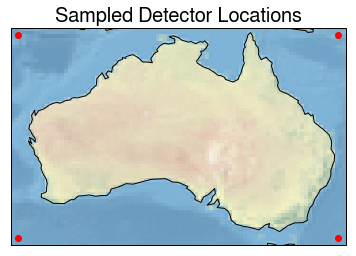

In [5]:
#-------- Create list of lat/longs & plot over map--------

#create meshgrid of lat/long inside a rectangle conatining australia
latitude_limits =  [-40.0,-11.0] #min/max values of lat/long
longitude_limits = [112.0,154.0]
number_of_latitude_points = 2
number_of_longitude_points = 2

#create a meshgrid of points within rectangle defined by the limits
mesh_lat, mesh_long = np.meshgrid(np.linspace(latitude_limits[0],latitude_limits[1],number_of_latitude_points),\
                                    np.linspace(longitude_limits[0],longitude_limits[1],number_of_longitude_points))

#flatten 2d co-ord matrices to 1-d vectors containing all combinations of points
proposed_latitude = [y for x in mesh_lat for y in x]
proposed_longitude = [y for x in mesh_long for y in x]


#---- Plot the sampled locations over map of Aus ----
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.stock_img()
plt.xlim(longitude_limits[0]-1,longitude_limits[1]+1)
plt.ylim(latitude_limits[0]-1,latitude_limits[1]+1)
plt.plot(proposed_longitude,proposed_latitude,color='red',marker='o',linestyle="")
plt.title("Sampled Detector Locations")
plt.show()



In [6]:
#-------- Create array of proposed detectors --------
newDetector=[]
for i in range(len(proposed_latitude)) :

    OZHF = bilby.gw.detector.Interferometer(power_spectral_density = bilby.gw.detector.PowerSpectralDensity(frequency_array=OZHF_freqs,psd_array=OZHF_psd)\
                                           ,name='OZHF',length=OZHF_gwinc.Infrastructure.Length, minimum_frequency=detector_min_freq,maximum_frequency=detector_max_freq\
                                           ,latitude=proposed_latitude[i],longitude=proposed_longitude[i],elevation=0\
                                            ,xarm_azimuth=detector_Xarm_aximuth,yarm_azimuth=detector_Yarm_aximuth)
    
    newDetector.append(OZHF)
OZHF_list = bilby.gw.detector.InterferometerList(newDetector)
OZHF_list.set_strain_data_from_power_spectral_densities(
sampling_frequency=sampling_frequency, duration=duration,
start_time=start_time)

/home/mitchell/bilby/bilby/gw/detector.py:1970: RuntimeWarning: invalid value encountered in multiply
  frequency_domain_strain = self.__power_spectral_density_interpolated(frequencies) ** 0.5 * white_noise


In [7]:
#------ Create and Setup Output file -----
try:
    fp = open('./OZHF_locations_with_H1_L1_V1_outdir/credible_levels.txt',mode='w')
except IOError:
    print('Error opening file, exiting ...')
    sys.exit
    

fp.write('%-14s\t%-14s\t%-14s\t%-14s\n' %("Latitude","Longitude","RA_Credible","Dec_Credible"))


60

In [8]:
#------- Use new network with sampler ------
np.random.seed(88170235)
i=0
for j in range(5):
    print("----\n")
ifos = bilby.gw.detector.InterferometerList(['H1','L1','V1']) #-?-Add detectors working at A+
ifos.set_strain_data_from_power_spectral_densities(
sampling_frequency=sampling_frequency, duration=duration,
start_time=start_time)
ifos.append(OZHF_list[i])


#----- inject signal into detectors -----
for interferometer in ifos:
    interferometer.set_strain_data_from_power_spectral_density(
        sampling_frequency=sampling_frequency, duration=duration,
        start_time=start_time)
    interferometer.inject_signal(parameters=injection_parameters,
                              waveform_generator=waveform_generator)

#----- create likelihood -----
likelihood = bilby.gw.GravitationalWaveTransient(
interferometers=ifos, waveform_generator=waveform_generator\
,time_marginalization=True,phase_marginalization=True,distance_marginalization=False\
,priors=priors)


#print(ifos)

#continue
#----- Run Sampler -----
sampler = 'nestle'
npoints = 50
result = bilby.core.sampler.run_sampler(likelihood=likelihood, priors=priors, outdir='OZHF_locations_with_H1_L1_V1_outdir',sampler=sampler,npoints=npoints\
                          ,injection_parameters=injection_parameters)

#----- write Credible Levels to file ----

fp.write("%-14d\t%-14d\t%-14d\t%-14d\n" %(proposed_latitude[i],proposed_longitude[i]\
                                 ,result.get_injection_credible_level('ra')\
                                ,result.get_injection_credible_level('dec')))


/home/mitchell/bilby/bilby/gw/detector.py:1970: RuntimeWarning: invalid value encountered in multiply
  frequency_domain_strain = self.__power_spectral_density_interpolated(frequencies) ** 0.5 * white_noise
16:36 bilby INFO    : Injected signal in H1:
16:36 bilby INFO    :   optimal SNR = 35.24
16:36 bilby INFO    :   matched filter SNR = 35.78-0.42j
16:36 bilby INFO    :   mass_1 = 1.5
16:36 bilby INFO    :   mass_2 = 1.3
16:36 bilby INFO    :   chi_1 = 0.02
16:36 bilby INFO    :   chi_2 = 0.02
16:36 bilby INFO    :   luminosity_distance = 50.0
16:36 bilby INFO    :   iota = 0.4
16:36 bilby INFO    :   psi = 2.659
16:36 bilby INFO    :   phase = 1.3
16:36 bilby INFO    :   geocent_time = 1126259642.413
16:36 bilby INFO    :   ra = 1.375
16:36 bilby INFO    :   dec = -1.2108
16:36 bilby INFO    :   lambda_1 = 400
16:36 bilby INFO    :   lambda_2 = 450
16:36 bilby INFO    : Injected signal in L1:
16:36 bilby INFO    :   optimal SNR = 28.54
16:36 bilby INFO    :   matched filter SNR = 29

----

----

----

----

----



16:36 bilby INFO    : Injected signal in OZHF:
16:36 bilby INFO    :   optimal SNR = 52.53
16:36 bilby INFO    :   matched filter SNR = 52.50+0.02j
16:36 bilby INFO    :   mass_1 = 1.5
16:36 bilby INFO    :   mass_2 = 1.3
16:36 bilby INFO    :   chi_1 = 0.02
16:36 bilby INFO    :   chi_2 = 0.02
16:36 bilby INFO    :   luminosity_distance = 50.0
16:36 bilby INFO    :   iota = 0.4
16:36 bilby INFO    :   psi = 2.659
16:36 bilby INFO    :   phase = 1.3
16:36 bilby INFO    :   geocent_time = 1126259642.413
16:36 bilby INFO    :   ra = 1.375
16:36 bilby INFO    :   dec = -1.2108
16:36 bilby INFO    :   lambda_1 = 400
16:36 bilby INFO    :   lambda_2 = 450
16:36 bilby INFO    : No prior given, using default BNS priors in /home/mitchell/bilby/bilby/gw/prior_files/binary_neutron_stars.prior.
/home/mitchell/bilby/bilby/gw/prior.py:65: RuntimeWarning: divide by zero encountered in true_divide
  z_prior.prob(x / aas)), aas) for x in xx]
/home/mitchell/bilby/bilby/gw/prior.py:65: RuntimeWarning: i

it=   803 logz=2876.7485064


16:37 bilby INFO    : Sampling time: 0:01:28.354246
16:37 bilby INFO    : Results saved to OZHF_locations_with_H1_L1_V1_outdir/
16:37 bilby INFO    : Summary of results:
nsamples: 854
log_noise_evidence: -47948.943
log_evidence: -45071.773 +/-  0.533
log_bayes_factor: 2877.169 +/-  0.533



60

In [9]:
#------- Use new network with sampler ------
np.random.seed(88170235)
i=1
for j in range(5):
    print("----\n")
ifos = bilby.gw.detector.InterferometerList(['H1','L1','V1']) #-?-Add detectors working at A+
ifos.set_strain_data_from_power_spectral_densities(
sampling_frequency=sampling_frequency, duration=duration,
start_time=start_time)
ifos.append(OZHF_list[i])


#----- inject signal into detectors -----
for interferometer in ifos:
    interferometer.set_strain_data_from_power_spectral_density(
        sampling_frequency=sampling_frequency, duration=duration,
        start_time=start_time)
    interferometer.inject_signal(parameters=injection_parameters,
                              waveform_generator=waveform_generator)

#----- create likelihood -----
likelihood = bilby.gw.GravitationalWaveTransient(
interferometers=ifos, waveform_generator=waveform_generator\
,time_marginalization=True,phase_marginalization=True,distance_marginalization=False\
,priors=priors)


#print(ifos)

#continue
#----- Run Sampler -----
sampler = 'nestle'
npoints = 50
result = bilby.core.sampler.run_sampler(likelihood=likelihood, priors=priors, outdir='OZHF_locations_with_H1_L1_V1_outdir',sampler=sampler,npoints=npoints\
                          ,injection_parameters=injection_parameters)

#----- write Credible Levels to file ----

fp.write("%-14d\t%-14d\t%-20d\t%-20d\n" %(proposed_latitude[i],proposed_longitude[i]\
                                 ,result.get_injection_credible_level('ra')\
                                ,result.get_injection_credible_level('dec')))


----

----

----

----

----



/home/mitchell/bilby/bilby/gw/detector.py:1970: RuntimeWarning: invalid value encountered in multiply
  frequency_domain_strain = self.__power_spectral_density_interpolated(frequencies) ** 0.5 * white_noise
16:37 bilby INFO    : Injected signal in H1:
16:37 bilby INFO    :   optimal SNR = 35.24
16:37 bilby INFO    :   matched filter SNR = 35.78-0.42j
16:37 bilby INFO    :   mass_1 = 1.5
16:37 bilby INFO    :   mass_2 = 1.3
16:37 bilby INFO    :   chi_1 = 0.02
16:37 bilby INFO    :   chi_2 = 0.02
16:37 bilby INFO    :   luminosity_distance = 50.0
16:37 bilby INFO    :   iota = 0.4
16:37 bilby INFO    :   psi = 2.659
16:37 bilby INFO    :   phase = 1.3
16:37 bilby INFO    :   geocent_time = 1126259642.413
16:37 bilby INFO    :   ra = 1.375
16:37 bilby INFO    :   dec = -1.2108
16:37 bilby INFO    :   lambda_1 = 400
16:37 bilby INFO    :   lambda_2 = 450
16:37 bilby INFO    : Injected signal in L1:
16:37 bilby INFO    :   optimal SNR = 28.54
16:37 bilby INFO    :   matched filter SNR = 29

/home/mitchell/anaconda3/lib/python3.6/site-packages/nestle.py:906: RuntimeWarning: invalid value encountered in double_scalars
  math.exp(logz - logz_new) * (h + logz) -
/home/mitchell/anaconda3/lib/python3.6/site-packages/nestle.py:970: RuntimeWarning: invalid value encountered in double_scalars
  math.exp(logz - logz_new) * (h + logz) -


ValueError: weights do not sum to 1

In [ ]:
fp.close()

In [20]:
result.samples[:,0]

array([-1.21261963, -1.21064629, -1.20986031, ..., -1.21090821,
       -1.21090821, -1.21090821])